# 기간을 달리해서 수익률을 살펴보고, 그에 따른 인사이트를 도출해 내자.



In [4]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY.csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-4-5e3713a76c3a>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-4-5e3713a76c3a>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  1993-01-29  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  1993-02-26  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-03-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-05-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-06-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-07-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-08-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-10-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-11-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1993-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1994-01-31  모멘텀 인덱스 :  0.08709204814662908 flag :  True signal :  buy SPY
날짜 :  1994-02-28  모멘텀 인덱스 :  0.11312922813301807 flag :  True signal :  buy SPY
날짜 :  1994-03-31  모멘텀 인덱스 :  0.0569902159342186 flag :  True signal :  buy SPY
날짜 :  1994-04-29  모멘텀 인덱스 :  0.03929465201089477 flag :  True sig

날짜 :  2002-05-31  모멘텀 인덱스 :  -0.13252772505245802 flag :  False signal :  
날짜 :  2002-06-28  모멘텀 인덱스 :  -0.1166243510758268 flag :  False signal :  
날짜 :  2002-07-31  모멘텀 인덱스 :  -0.1733960732590436 flag :  False signal :  
날짜 :  2002-08-30  모멘텀 인덱스 :  -0.1905202523648043 flag :  False signal :  
날짜 :  2002-09-30  모멘텀 인덱스 :  -0.11257511760923766 flag :  False signal :  
날짜 :  2002-10-31  모멘텀 인덱스 :  -0.21583404664514483 flag :  False signal :  
날짜 :  2002-11-29  모멘텀 인덱스 :  -0.2127008343050788 flag :  False signal :  
날짜 :  2002-12-31  모멘텀 인덱스 :  -0.16882691855596665 flag :  False signal :  
날짜 :  2003-01-31  모멘텀 인덱스 :  -0.20808665538265336 flag :  False signal :  
날짜 :  2003-02-28  모멘텀 인덱스 :  -0.2134561674474923 flag :  False signal :  
날짜 :  2003-03-31  모멘텀 인덱스 :  -0.2490425352667468 flag :  False signal :  
날짜 :  2003-04-30  모멘텀 인덱스 :  -0.20096754878994239 flag :  False signal :  
날짜 :  2003-05-30  모멘텀 인덱스 :  -0.12818731382473403 flag :  False signal :  
날짜 :  2003-06-30  모멘텀 인덱스 :  -0

날짜 :  2018-05-31  모멘텀 인덱스 :  0.11646678636963914 flag :  True signal :  buy SPY
날짜 :  2018-06-29  모멘텀 인덱스 :  0.13636242290258038 flag :  True signal :  buy SPY
날짜 :  2018-07-31  모멘텀 인덱스 :  0.11987953232330129 flag :  True signal :  buy SPY
날짜 :  2018-08-31  모멘텀 인덱스 :  0.15798789954743553 flag :  True signal :  buy SPY
날짜 :  2018-09-28  모멘텀 인덱스 :  0.1713490477742199 flag :  True signal :  buy SPY
날짜 :  2018-10-31  모멘텀 인덱스 :  0.15118699767145283 flag :  True signal :  buy SPY
날짜 :  2018-11-30  모멘텀 인덱스 :  0.03985102498169546 flag :  True signal :  buy SPY
날짜 :  2018-12-31  모멘텀 인덱스 :  0.04644822513547742 flag :  True signal :  buy SPY
날짜 :  2019-01-31  모멘텀 인덱스 :  -0.09660464628378684 flag :  False signal :  
날짜 :  2019-02-28  모멘텀 인덱스 :  0.012542838197935113 flag :  True signal :  buy SPY
날짜 :  2019-03-29  모멘텀 인덱스 :  0.07482660744817426 flag :  True signal :  buy SPY
날짜 :  2019-04-30  모멘텀 인덱스 :  0.08865546196011187 flag :  True signal :  buy SPY
날짜 :  2019-05-31  모멘텀 인덱스 :  0.10623750367520

16.4076

# 데이터의 기간을 달리 해서 수익률 관찰.

위의 코드를 그대로 사용하되, 데이터의 기간을 달리 해서 
각 기간별의 수익률을 구한다.

데이터 파일의 이름을 통해서, 기간을 명시한다.


# 1.5년

In [5]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY(2018-2023).csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-5-c0a792946055>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-5-c0a792946055>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  2018-11-30  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2018-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-01-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-02-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-03-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-05-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-06-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-08-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-11-29  모멘텀 인덱스 :  0.12228425883358285 flag :  True signal :  buy SPY
날짜 :  2019-12-31  모멘텀 인덱스 :  0.27518716035870416 flag :  True signal :  buy SPY
날짜 :  2020-01-31  모멘텀 인덱스 :  0.2149618439536809 flag :  True signal :  buy SPY
날짜 :  2020-02-28  모멘텀 인덱스 :  0.1763392797414376 flag :  True sign

1.3049

# 2. 10년

In [6]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY (2013-2023).csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-6-592774bc1a31>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-6-592774bc1a31>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  2013-01-31  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2013-02-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-03-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-05-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-06-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-08-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-11-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2013-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2014-01-31  모멘텀 인덱스 :  0.2586475017022729 flag :  True signal :  buy SPY
날짜 :  2014-02-28  모멘텀 인덱스 :  0.19898464978077923 flag :  True signal :  buy SPY
날짜 :  2014-03-31  모멘텀 인덱스 :  0.2076995794478096 flag :  True signal :  buy SPY
날짜 :  2014-04-30  모멘텀 인덱스 :  0.19476350341409265 flag :  True sign

청산일 :  2015-10-30 long 진입가격 :  149.315979  |  long 청산가격 :  180.244675  | return: 1.2071
진입일 :  2015-11-30 long 진입가격 :  180.903488
청산일 :  2016-02-29 long 진입가격 :  180.903488  |  long 청산가격 :  168.786606  | return: 0.933
진입일 :  2016-04-29 long 진입가격 :  180.850174
청산일 :  2016-05-31 long 진입가격 :  180.850174  |  long 청산가격 :  183.926666  | return: 1.017
진입일 :  2016-06-30 long 진입가격 :  184.565979
청산일 :  2019-01-31 long 진입가격 :  184.565979  |  long 청산가격 :  249.766983  | return: 1.3533
진입일 :  2019-02-28 long 진입가격 :  257.863312
청산일 :  2020-04-30 long 진입가격 :  257.863312  |  long 청산가격 :  275.482025  | return: 1.0683
진입일 :  2020-05-29 long 진입가격 :  288.607391
청산일 :  2022-05-31 long 진입가격 :  288.607391  |  long 청산가격 :  403.125793  | return: 1.3968
진입일 :  2023-04-28 long 진입가격 :  412.934143
Accunulated return : 2.3131


2.3131

# 3. 15년


In [7]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY (2008-2023).csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-7-a6bd1057bcd0>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-7-a6bd1057bcd0>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  2008-01-31  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2008-02-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-03-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-05-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-06-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-08-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-11-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2008-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2009-01-30  모멘텀 인덱스 :  -0.3272766131666238 flag :  False signal :  
날짜 :  2009-02-27  모멘텀 인덱스 :  -0.3661358855811836 flag :  False signal :  
날짜 :  2009-03-31  모멘텀 인덱스 :  -0.42913944645643887 flag :  False signal :  
날짜 :  2009-04-30  모멘텀 인덱스 :  -0.4097147027812017 flag :  False signal :  
날짜 :  2

날짜 :  2023-03-31  모멘텀 인덱스 :  -0.1111471093404689 flag :  False signal :  
날짜 :  2023-04-28  모멘텀 인덱스 :  0.010500252145687172 flag :  True signal :  buy SPY
날짜 :  2023-05-31  모멘텀 인덱스 :  0.024330668417438694 flag :  True signal :  buy SPY
날짜 :  2023-06-30  모멘텀 인덱스 :  0.12154206579226412 flag :  True signal :  buy SPY
날짜 :  2023-07-31  모멘텀 인덱스 :  0.09351846862638613 flag :  True signal :  buy SPY
날짜 :  2023-08-31  모멘텀 인덱스 :  0.17735111320445096 flag :  True signal :  buy SPY
날짜 :  2023-09-29  모멘텀 인덱스 :  0.2761959628763291 flag :  True signal :  buy SPY
날짜 :  2023-10-31  모멘텀 인덱스 :  0.1242835818793464 flag :  True signal :  buy SPY
날짜 :  2023-11-17  모멘텀 인덱스 :  0.04195305508799163 flag :  True signal :  buy SPY
진입일 :  2009-10-30 long 진입가격 :  79.513329
청산일 :  2011-10-31 long 진입가격 :  79.513329  |  long 청산가격 :  100.216194  | return: 1.2604
진입일 :  2011-11-30 long 진입가격 :  99.808929
청산일 :  2012-01-31 long 진입가격 :  99.808929  |  long 청산가격 :  105.528732  | return: 1.0573
진입일 :  2012-02-29 long 진입가격 : 

4.18

# 4. 20년



In [8]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY (2003-2023).csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-8-918f044eb483>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-8-918f044eb483>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  2003-01-31  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2003-02-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-03-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-05-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-06-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-08-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-11-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2003-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2004-01-30  모멘텀 인덱스 :  0.3141361792829038 flag :  True signal :  buy SPY
날짜 :  2004-02-27  모멘텀 인덱스 :  0.35842686017615755 flag :  True signal :  buy SPY
날짜 :  2004-03-31  모멘텀 인덱스 :  0.373922849478739 flag :  True signal :  buy SPY
날짜 :  2004-04-30  모멘텀 인덱스 :  0.24996277878401307 flag :  True signa

날짜 :  2019-01-31  모멘텀 인덱스 :  -0.09660436283962692 flag :  False signal :  
날짜 :  2019-02-28  모멘텀 인덱스 :  0.01254264937722982 flag :  True signal :  buy SPY
날짜 :  2019-03-29  모멘텀 인덱스 :  0.07482706779302828 flag :  True signal :  buy SPY
날짜 :  2019-04-30  모멘텀 인덱스 :  0.08865522455044283 flag :  True signal :  buy SPY
날짜 :  2019-05-31  모멘텀 인덱스 :  0.10623769635107272 flag :  True signal :  buy SPY
날짜 :  2019-06-28  모멘텀 인덱스 :  0.029769708735803757 flag :  True signal :  buy SPY
날짜 :  2019-07-31  모멘텀 인덱스 :  0.06208148729363194 flag :  True signal :  buy SPY
날짜 :  2019-08-30  모멘텀 인덱스 :  0.04478948119424997 flag :  True signal :  buy SPY
날짜 :  2019-09-30  모멘텀 인덱스 :  0.0212247359188229 flag :  True signal :  buy SPY
날짜 :  2019-10-31  모멘텀 인덱스 :  0.11838073525826642 flag :  True signal :  buy SPY
날짜 :  2019-11-29  모멘텀 인덱스 :  0.12228468047243646 flag :  True signal :  buy SPY
날짜 :  2019-12-31  모멘텀 인덱스 :  0.27518755386933513 flag :  True signal :  buy SPY
날짜 :  2020-01-31  모멘텀 인덱스 :  0.21496223897721

5.3028

# 5. 25년

In [9]:
#먼저, 1번 주피터 파일의 통합 코드이다. 자세한 설명은 1번파일에 다 적어놓았으니, 
#이 파일에서는 결과만 보도록 하자.

#1.필요한 라이브러리 import

import pandas as pd
import numpy as np
import datetime #날짜를 계산하기 위해 import 한다.


#데이터를 읽어들이고, 상위 5개의 행을 불러온다.
read_df = pd.read_csv('data/SPY (1998-2023).csv')


#2.종가 데이터만 추출
Close_df = read_df.loc[:,['Date','Adj Close']].copy()  #데이터를 안전하게 복사하기 위해 copy 매소드를 사용한다.



#3.월말 데이터만 사용하는 코드 작성
Close_df['year_month'] = Close_df['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
#strptime은 datetime을 원하는 형식으로 나타나게 하고 strftime은  그 중에서 알맞은 형식으로 데이터를 바꾼다.


#4.월말 종가에 접근하는 데이터 프레임 작성
month_list = Close_df['year_month'].unique()
#month의 list를 만들자.


import pandas as pd

# Assuming you have a DataFrame named Close_df with a 'year_month' column
# and a DataFrame named month_list_df that you want to create

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = Close_df[Close_df['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(Close_df.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

#5. 데이터 가공

month_list_df['BF_1M_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['BF_1YEAR_Adj Close'] = month_list_df.shift(12)['Adj Close'] #12개월 전 종가 데이터를 가져온다.
month_list_df.fillna(0, inplace=True) #na값을 채운다. 종가를 땡겨오는데, na값이 나는 것은 당연하다.


#6.포지션 기록

position = Close_df.copy()
position.set_index(['Date'],inplace=True) #set_index를 통해 date를 index로 만든다.
position['trade'] = '' #trade부분을 이제부터 채울 것이므로, 빈 데이터로 만든다.


#7.trading 부분.
ticker = 'SPY'
for x in month_list_df.index: #index를 붙여서, 데이터를 다 불러올 수 있도록 한다.
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum > 0.0) and (momentum != np.inf) and (momentum != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum, 'flag : ',flag ,'signal : ',signal)
    position.loc[x:,'trade'] = signal

#8.수익률 확인

#함수 작성!
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, 'Adj Close']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
        
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0
        
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))


returns(position,ticker)

<ipython-input-9-d298ae10d9a6>:70: RuntimeWarning: invalid value encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1
<ipython-input-9-d298ae10d9a6>:70: RuntimeWarning: divide by zero encountered in double_scalars
  momentum = month_list_df.loc[x,'BF_1M_Adj Close'] / month_list_df.loc[x,'BF_1YEAR_Adj Close'] -1


날짜 :  1998-01-30  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  1998-02-27  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-03-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-05-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-06-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-08-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-10-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-11-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1998-12-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  1999-01-29  모멘텀 인덱스 :  0.2705616167321587 flag :  True signal :  buy SPY
날짜 :  1999-02-26  모멘텀 인덱스 :  0.2300807687060915 flag :  True signal :  buy SPY
날짜 :  1999-03-31  모멘텀 인덱스 :  0.13525160553319737 flag :  True signal :  buy SPY
날짜 :  1999-04-30  모멘텀 인덱스 :  0.16739530320300156 flag :  True sign

날짜 :  2014-03-31  모멘텀 인덱스 :  0.20769969548931 flag :  True signal :  buy SPY
날짜 :  2014-04-30  모멘텀 인덱스 :  0.19476360268381043 flag :  True signal :  buy SPY
날짜 :  2014-05-30  모멘텀 인덱스 :  0.17531984754885488 flag :  True signal :  buy SPY
날짜 :  2014-06-30  모멘텀 인덱스 :  0.21886049252912354 flag :  True signal :  buy SPY
날짜 :  2014-07-31  모멘텀 인덱스 :  0.18289501353153703 flag :  True signal :  buy SPY
날짜 :  2014-08-29  모멘텀 인덱스 :  0.20308301687217556 flag :  True signal :  buy SPY
날짜 :  2014-09-30  모멘텀 인덱스 :  0.21219861993617894 flag :  True signal :  buy SPY
날짜 :  2014-10-31  모멘텀 인덱스 :  0.14256640570732348 flag :  True signal :  buy SPY
날짜 :  2014-11-28  모멘텀 인덱스 :  0.1358127367628077 flag :  True signal :  buy SPY
날짜 :  2014-12-31  모멘텀 인덱스 :  0.1375234633961071 flag :  True signal :  buy SPY
날짜 :  2015-01-30  모멘텀 인덱스 :  0.17609291071658428 flag :  True signal :  buy SPY
날짜 :  2015-02-27  모멘텀 인덱스 :  0.09156277862770423 flag :  True signal :  buy SPY
날짜 :  2015-03-31  모멘텀 인덱스 :  0.14342843895327

진입일 :  1999-01-29 long 진입가격 :  81.857346
청산일 :  2000-12-29 long 진입가격 :  81.857346  |  long 청산가격 :  85.920906  | return: 1.0496
진입일 :  2001-02-28 long 진입가격 :  81.180717
청산일 :  2001-03-30 long 진입가격 :  81.180717  |  long 청산가격 :  76.631584  | return: 0.944
진입일 :  2003-07-31 long 진입가격 :  67.485847
청산일 :  2008-02-29 long 진입가격 :  67.485847  |  long 청산가격 :  98.589859  | return: 1.4609
진입일 :  2009-10-30 long 진입가격 :  79.513359
청산일 :  2011-10-31 long 진입가격 :  79.513359  |  long 청산가격 :  100.216217  | return: 1.2604
진입일 :  2011-11-30 long 진입가격 :  99.808922
청산일 :  2012-01-31 long 진입가격 :  99.808922  |  long 청산가격 :  105.528763  | return: 1.0573
진입일 :  2012-02-29 long 진입가격 :  110.109245
청산일 :  2015-10-30 long 진입가격 :  110.109245  |  long 청산가격 :  180.244705  | return: 1.637
진입일 :  2015-11-30 long 진입가격 :  180.903473
청산일 :  2016-02-29 long 진입가격 :  180.903473  |  long 청산가격 :  168.786606  | return: 0.933
진입일 :  2016-04-29 long 진입가격 :  180.850159
청산일 :  2016-05-31 long 진입가격 :  180.850159  |  long 청산가격 :  183.9

6.0505

In [14]:
#위의 데이터들을 보면, 


#5년 1.3049(약 1.3배)(2018-2023)
#10년 2.3131(2013-2023)
#15년 4.18(2008-2023)
#20년 5.3028(2003-2023)
#25년 6.0505(약 6배)
#30년 16.4076(1번 파일에 했던 데이터)


#이런 식으로 수익률이 난 것을 볼 수 있다.

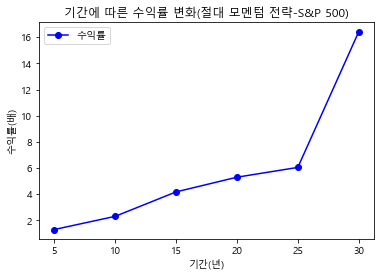

In [13]:
#위의 수익률을 그래프로 나타내면 다음과 같다.

import matplotlib.pyplot as plt

# Data
x_values = [5, 10, 15, 20, 25,30]
y_values = [1.3049, 2.3131, 4.18, 5.3028, 6.0505,16.4076]

# Plotting the data
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='수익률')

# Adding labels and title
plt.xlabel('기간(년)')
plt.ylabel('수익률(배)')
plt.title('기간에 따른 수익률 변화(절대 모멘텀 전략-S&P 500)')
plt.legend()  # Display the legend if you have multiple plots

# Show the plot
plt.show()

# 결론(인사이트)

- 1.절대 모멘텀 전략을 활용하면, 긴 기간동안 안정적인 수익을 가져갈 수 있다. 위 데이터는 1994년부터 2023년까지의 데이터인데, 그래프가 꾸준히 우상향하는 것을 볼 수 있다.

- 2. 절대 모멘텀 전략은 위기 상황 속에서도 유효하다. 2000년대 초반의 IT버블, 2008년의 서브-프라임 모기지 사태의 위기도 비교적 잘 넘긴 것을 볼 수 있다.(적어도 수익률이 다시 줄어들거나 하지는 않았다.)

- 3.단, 이렇게 수익을 내기 위해서는, 긴 시간 동안 인내할 수 있는 인내심이 중요하다. 1년은 고사하고 최소 5년은 길게 바라봐야 하는 인내심이 필요하다. 특히, 기간이 짧을 때는 수익률이 낮은데, 이 기간을 잘 버티는 것이 중요하다.

- 4.머신러닝,딥러닝을 이용해서 위와 같은 투자 기법을 더 효율적으로 구사할 수 있을 것이다. 그러기 위해 knn과 rnn을 알아보자. knn을 통해 spy지수(앞서 보았던 etf s&p 500 데이터)를 예측하는 모델을 설계하고, 정확도를 높임으로서 더 쉽게 투자 할 수 있도록 하자.